In [1]:
# RFM模型是美国数据库营销研究所提出的用户分群模型。RFM为最近一次消费至今的时间（Recency）、一定时间内重复消费频率（Frequency）、一定时间内重复消费频率（Monetary）三个重要指
# 标的简写。这三个指标分别代表了用户的忠诚度、活跃度及付费情况，根据这三个指标的值可以将用户分为八个类别。
# R：离得越远，用户越有流失可能，越应该唤醒用户,F：频次越低，越需要用一次性手段（比如促销、赠礼），频次越高，越可以用持续性手段（积分） 来维护,M：消费越多，用户价值越高，越应该重点关注。

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['font.sans-serif']=['Microsoft YaHei']
import seaborn as sns

In [49]:
df=pd.read_excel(r"D:\jupyter\data\Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<AxesSubplot:>

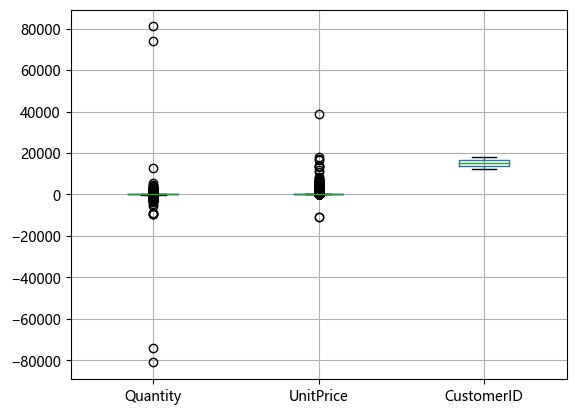

In [50]:
# 数据预处理
df.isnull().sum()
df.boxplot() # 通过箱线图可以看到数量和商品价格中存在负值，不合理，故需要删除

<AxesSubplot:>

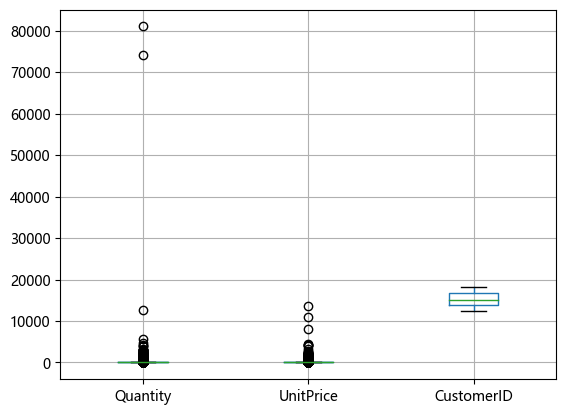

In [51]:
df=df.loc[df['Quantity']>=0]
df=df.loc[df['UnitPrice']>=0]
df.boxplot()

In [52]:
# 查看数据类型
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [53]:
# 对时间数据进行处理，仅保留年月日
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'].apply(lambda s:s.date()))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [54]:
# 计算RFM所需指标
# 计算每一次消费金额
df['total']=df['Quantity'] * df['UnitPrice']
last_date=max(df.InvoiceDate) + dt.timedelta(days=1)
# 计算时间间隔
def time_interval(date):
    return (last_date-date.max()).days

In [55]:
# 对每一个用户进行分组聚合,并计算RFM模型的三个指标
rfm=df.groupby(['CustomerID']).agg({
    'InvoiceDate':time_interval,
    'InvoiceNo':'count',
    'total':'sum'}).sort_index(ascending=True)
rfm.rename(columns={'InvoiceDate':'recency',
                    'InvoiceNo':'frequency',
                    'total':'monetary'},inplace=True)
rfm

,recency,frequency,monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


<AxesSubplot:xlabel='monetary', ylabel='Density'>

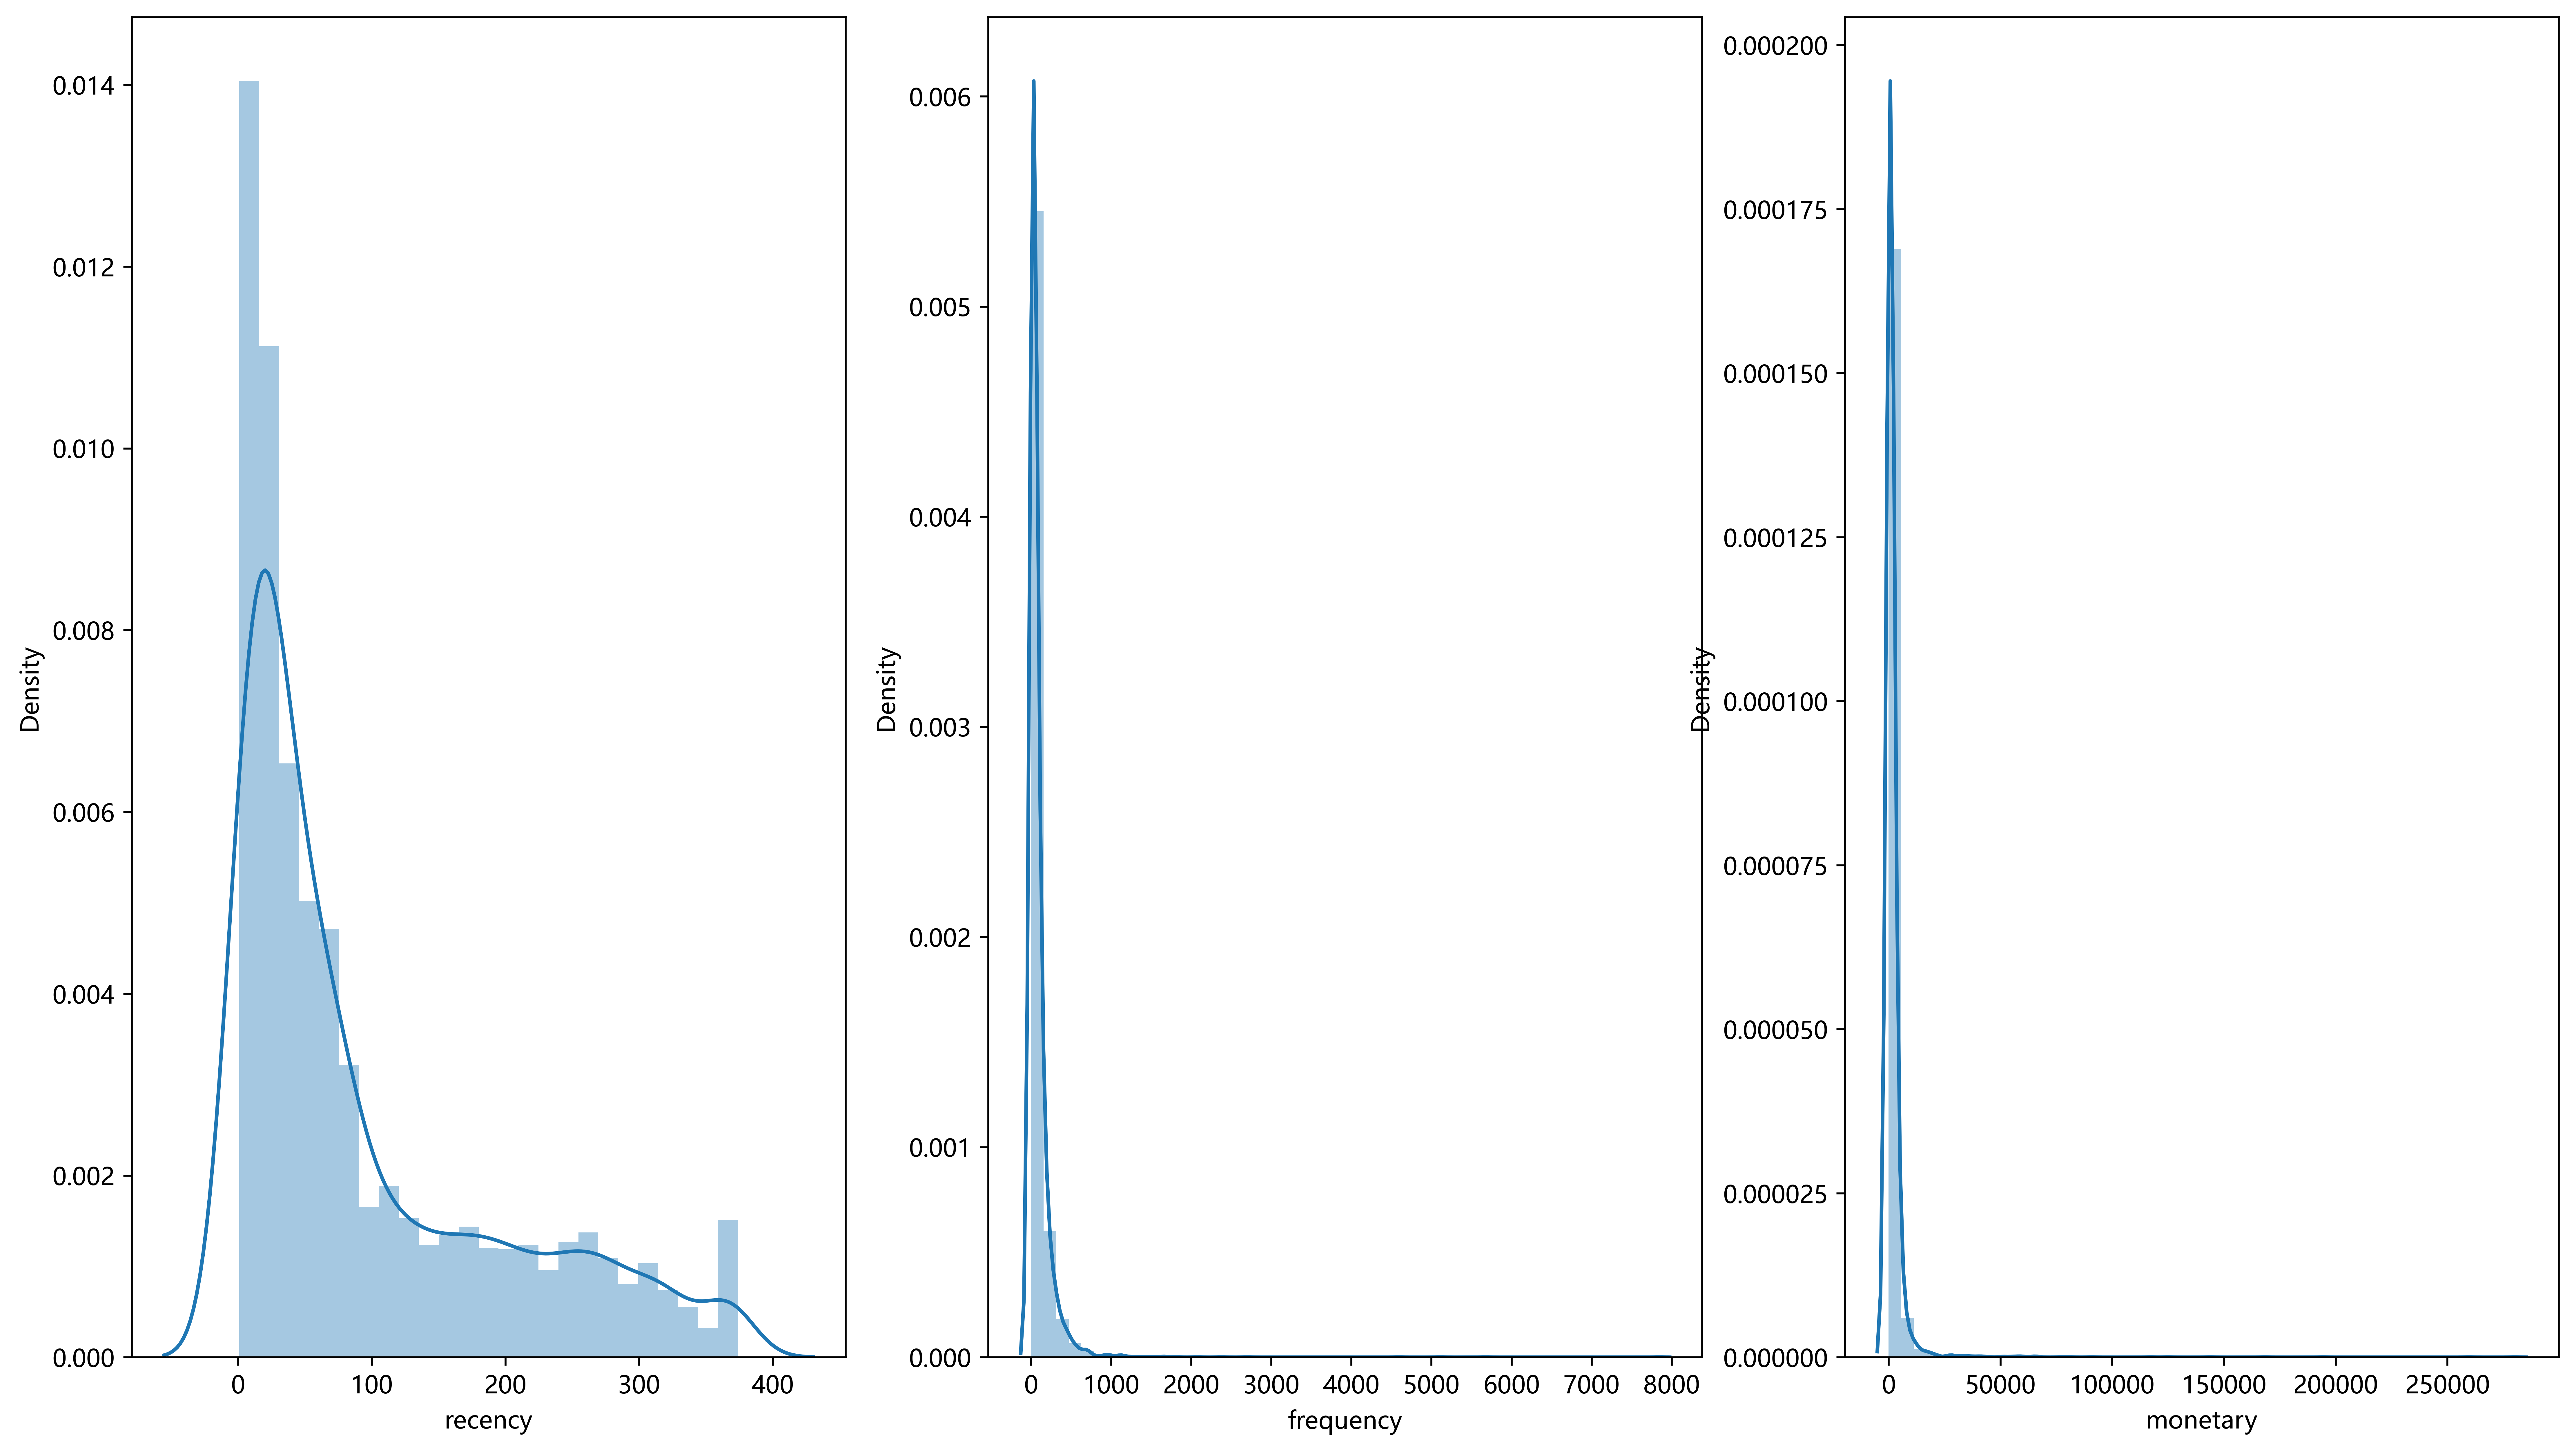

In [56]:
# 对RFM的三个指标可视化
figure,ax=plt.subplots(1,3,figsize=(18,10),dpi=600)
sns.distplot(rfm['recency'],ax=ax[0])
sns.distplot(rfm['frequency'],ax=ax[1])
sns.distplot(rfm['monetary'],ax=ax[2])

In [57]:
# 对数据进行分箱处理，增强模型的稳定性，避免过拟合
labels=list(range(1,5))
labels_reverse=list(range(4,0,-1))
rquart=pd.qcut(rfm['recency'],4,labels=labels_reverse)
fquart=pd.qcut(rfm['frequency'],4,labels=labels)
mquart=pd.qcut(rfm['monetary'],4,labels=labels)

In [58]:
# 对rmf三个指标进行评分
rfm['R']=rquart.values
rfm['F']=fquart.values
rfm['M']=mquart.values

In [59]:
# 计算rfm总分数
rfm['total_score']=rfm[['R','F','M']].sum(axis=1)
rfm

,recency,frequency,monetary,R,F,M,total_score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,6
12347.0,3,182,4310.00,4,4,4,12
12348.0,76,31,1797.24,2,2,4,8
12349.0,19,73,1757.55,3,3,4,10
12350.0,311,17,334.40,1,1,2,4
...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,3
18281.0,181,7,80.82,1,1,1,3
18282.0,8,12,178.05,4,1,1,6


In [60]:
# 给用户添加标签
cust_labels=['普通用户','发展用户','保持用户','价值用户']
rfm['cust_type']=pd.qcut(rfm['total_score'],4,labels=cust_labels).values
rfm.head()

,recency,frequency,monetary,R,F,M,total_score,cust_type
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,6,发展用户
12347.0,3,182,4310.00,4,4,4,12,价值用户
12348.0,76,31,1797.24,2,2,4,8,保持用户
12349.0,19,73,1757.55,3,3,4,10,保持用户
12350.0,311,17,334.40,1,1,2,4,普通用户


In [61]:
# 计算各个类型用户数量
type_count=rfm['cust_type'].value_counts().sort_index(ascending=True)
type_count

普通用户    1287
发展用户     917
保持用户    1300
价值用户     835
Name: cust_type, dtype: int64

In [62]:
# kmeans实现用户分群
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans

In [63]:
data_kmeans=rfm[['recency','frequency','monetary']]
data_kmeans_copy=data_kmeans.copy()

In [64]:
# 首先进行数据预处理，由于三个指标间量值相差较大，需要数据标准化
data_kmeans=np.log(data_kmeans+1)
model=preprocessing.StandardScaler()
data_kmeans[['recency','frequency','monetary']]=model.fit_transform(data_kmeans[['recency','frequency','monetary']])
data_kmeans

,recency,frequency,monetary
CustomerID,,,
12346.0,1.479129,-2.432827,3.696168
12347.0,-1.890519,1.177369,1.408758
12348.0,0.372543,-0.216521,0.715517
12349.0,-0.658991,0.453609,0.697821
12350.0,1.443198,-0.676446,-0.615877
...,...,...,...
18280.0,1.357656,-1.070114,-1.102307
18281.0,1.030762,-1.324674,-1.734438
18282.0,-1.270002,-0.936577,-1.113519


<AxesSubplot:xlabel='monetary', ylabel='Density'>

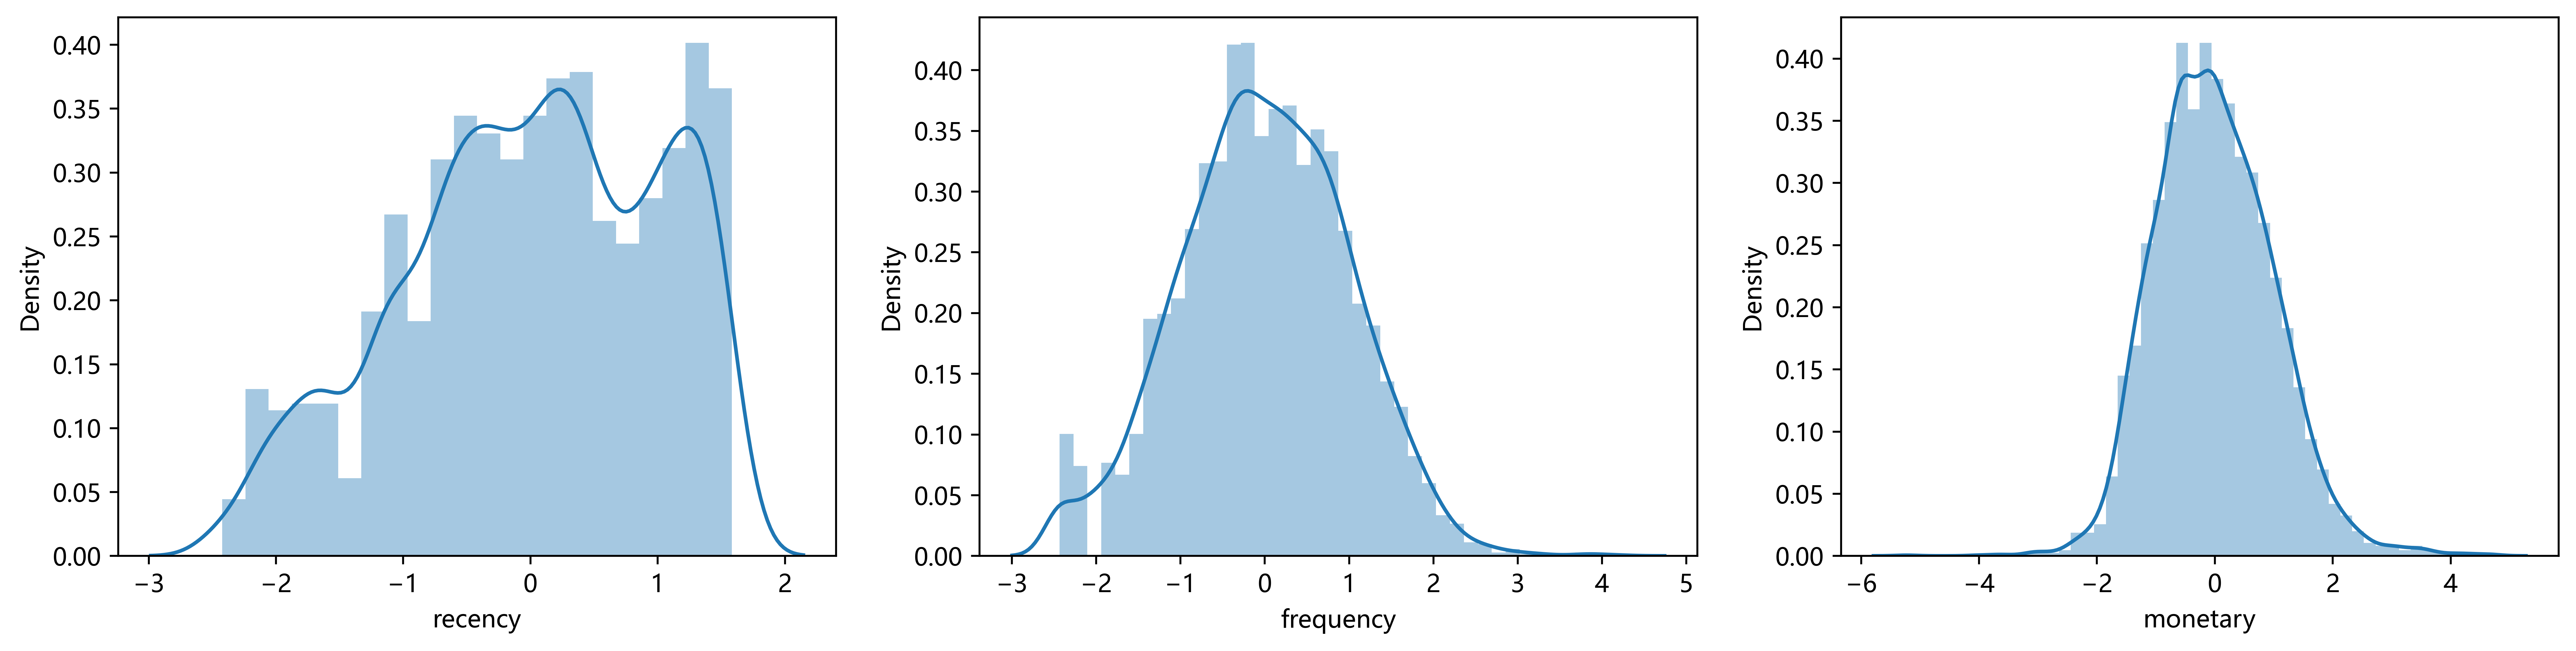

In [65]:
# 查看标准化后的分布情况
figure,ax=plt.subplots(1,3,figsize=(18,4),dpi=600)
sns.distplot(data_kmeans['recency'],ax=ax[0])
sns.distplot(data_kmeans['frequency'],ax=ax[1])
sns.distplot(data_kmeans['monetary'],ax=ax[2])

In [66]:
# 确定最优k值
x=np.array(data_kmeans[['recency','frequency','monetary']])

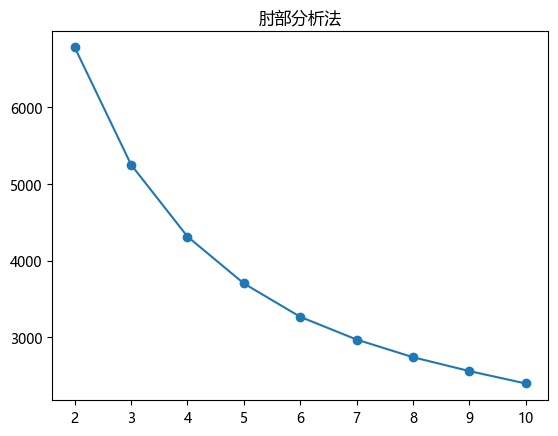

In [67]:
# 肘部法
dis=[]
for i in range(2,11):
    model=KMeans(n_clusters=i,init='k-means++',random_state=123,max_iter=1000)
    model.fit(x)
    inertia=model.inertia_
    dis.append(inertia)
plt.plot(range(2,11),dis,marker='o')
plt.title('肘部分析法')
plt.show() # 貌似在3或者4处

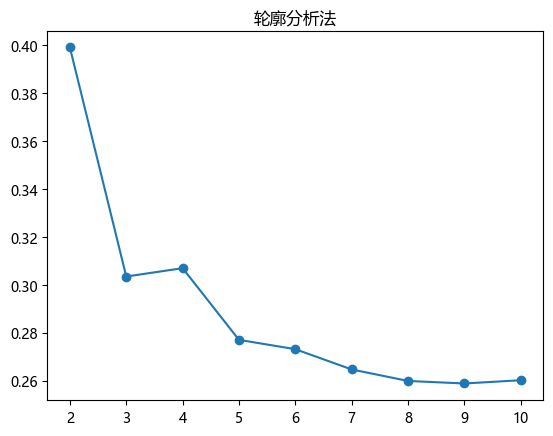

In [68]:
# 轮廓分析法
from sklearn.metrics import silhouette_score
sil_score=[]
for j in range(2,11):
    model=KMeans(n_clusters=j,init='k-means++',random_state=1234,max_iter=1000)
    model.fit(x)
    sil=silhouette_score(x,model.labels_)
    sil_score.append(sil)
plt.plot(range(2,11),sil_score,marker='o')
plt.title('轮廓分析法')
plt.show() # 由上图可以明显看出在k=4时，指标有较明显的变化趋势

In [69]:
# 聚类
model=KMeans(n_clusters=4,random_state=12345,max_iter=1000)
model.fit(x)
labels=pd.DataFrame(model.labels_,columns=['cust_labels'])
kmeans_result=pd.DataFrame(model.cluster_centers_,columns=['recency','frequency','monetary'])
kmeans_result['count']=labels['cust_labels'].value_counts().sort_index()
kmeans_result

,recency,frequency,monetary,count
0,0.447158,0.335626,0.319268,1168
1,0.889310,-0.999205,-0.933342,1345
2,-1.114116,1.235347,1.268174,910
3,-0.763089,-0.193903,-0.302347,916


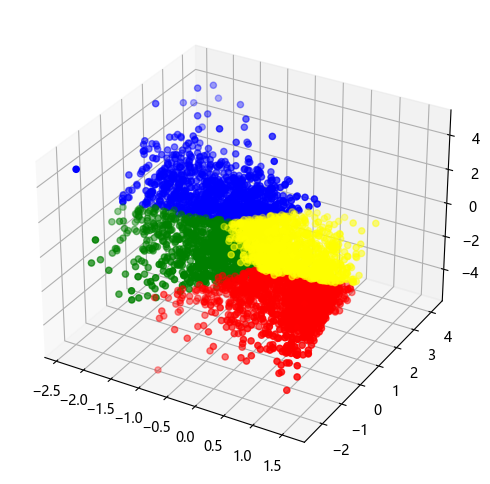

In [70]:
# 对聚类结果进行可视化
data_kmeans['cust_labels']=model.labels_
plt.figure(figsize=(15,6))
ax=plt.subplot(121,projection='3d')
label_0=data_kmeans.loc[data_kmeans.cust_labels==0]
label_1=data_kmeans.loc[data_kmeans.cust_labels==1]
label_2=data_kmeans.loc[data_kmeans.cust_labels==2]
label_3=data_kmeans.loc[data_kmeans.cust_labels==3]
ax.scatter(label_0['recency'],label_0['frequency'],label_0['monetary'],color='yellow')
ax.scatter(label_1['recency'],label_1['frequency'],label_1['monetary'],color='red')
ax.scatter(label_2['recency'],label_2['frequency'],label_2['monetary'],color='blue')
ax.scatter(label_3['recency'],label_3['frequency'],label_3['monetary'],color='green')

In [72]:
# 聚类含义解释
data_kmeans_copy['cust_label']=model.labels_
label_desc=data_kmeans_copy.groupby('cust_label').agg({'recency':np.median,
                                                       'frequency':np.median,
                                                       'monetary':np.median})
label_desc['count']=data_kmeans_copy['cust_label'].value_counts().sort_index()
label_desc_reset=label_desc.reset_index()
label_desc_reset

,cust_label,recency,frequency,monetary,count
0,0,78.0,63.0,1046.840,1168
1,1,186.0,12.0,237.610,1345
2,2,10.5,186.5,3110.475,910
3,3,19.0,34.0,510.915,916


In [73]:
# 分箱处理
print('Min  = {}, Max  = {}'.format(min(data_kmeans_copy.monetary	), max(data_kmeans_copy.monetary)))
x=range(100,280206,100)
monetary_1 = pd.cut(data_kmeans_copy['monetary'],len(x),labels=x)
data_kmeans_copy= data_kmeans_copy.assign(M1 = monetary_1.values).reset_index()
data_kmeans_copy

Min  = 0.0, Max  = 280206.02


,CustomerID,recency,frequency,monetary,cust_label,M1
0,12346.0,326,1,77183.60,0,77200
1,12347.0,3,182,4310.00,2,4400
2,12348.0,76,31,1797.24,0,1800
3,12349.0,19,73,1757.55,2,1800
4,12350.0,311,17,334.40,1,400
...,...,...,...,...,...,...
4334,18280.0,278,10,180.60,1,200
4335,18281.0,181,7,80.82,1,100
4336,18282.0,8,12,178.05,3,200
4337,18283.0,4,756,2094.88,2,2100


In [74]:
#统计用户的数据分布
data_r=data_kmeans_copy.groupby(["recency","cust_label"]).agg({'CustomerID':'count'}).reset_index()
data_r.rename(columns = {'recency': 'R','cust_label':'cust_label','CustomerID': 'Count'}, inplace=True)
data_f=data_kmeans_copy.groupby(["frequency","cust_label"]).agg({'CustomerID':'count'}).reset_index()
data_f.rename(columns = {'frequency': 'F','cust_label':'cust_label','CustomerID': 'Count'}, inplace=True)
data_m=data_kmeans_copy.groupby(["M1","cust_label"]).agg({'CustomerID':'count'}).reset_index()
data_m.rename(columns = {'M1': 'M','cust_label':'cust_label','CustomerID': 'Count'}, inplace=True)

In [75]:
#绘制R四个类型的可视化图形
plt.figure(figsize=(15,15),dpi=600)
ax = plt.subplot(3,4,1)
ax.plot(data_r.loc[data_r.cust_label==0,'R'],data_r.loc[data_r.cust_label==0,'Count'],c='y',label='0',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("R")
ax = plt.subplot(3,4,2)
ax.plot(data_r.loc[data_r.cust_label==1,'R'],data_r.loc[data_r.cust_label==1,'Count'],c='r',label='1',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("R")
ax = plt.subplot(3,4,3)
ax.plot(data_r.loc[data_r.cust_label==2,'R'],data_r.loc[data_r.cust_label==2,'Count'],c='g',label='2',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("R")
ax = plt.subplot(3,4,4)
ax.plot(data_r.loc[data_r.cust_label==3,'R'],data_r.loc[data_r.cust_label==3,'Count'],c='b',label='3',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("R")
#绘制F四个类型的可视化图形
ax = plt.subplot(3,4,5)
ax.plot(data_f.loc[data_f.cust_label==0,'F'],data_f.loc[data_f.cust_label==0,'Count'],c='y',label='0',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("F")
ax = plt.subplot(3,4,6)
ax.plot(data_f.loc[data_f.cust_label==1,'F'],data_f.loc[data_f.cust_label==1,'Count'],c='r',label='1',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("F")
ax = plt.subplot(3,4,7)
ax.plot(data_f.loc[data_f.cust_label==2,'F'],data_f.loc[data_f.cust_label==2,'Count'],c='g',label='2',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("F")
ax = plt.subplot(3,4,8)
ax.plot(data_f.loc[data_f.cust_label==3,'F'],data_f.loc[data_f.cust_label==3,'Count'],c='b',label='3',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("F")
#绘制M四个类型的可视化图形
ax = plt.subplot(3,4,9)
ax.plot(data_m.loc[data_m.cust_label==0,'M'].astype("int"),data_m.loc[data_m.cust_label==0,'Count'],c='y',label='0',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("M")
ax = plt.subplot(3,4,10)
ax.plot(data_m.loc[data_m.cust_label==1,'M'].astype("int"),data_m.loc[data_m.cust_label==1,'Count'],c='r',label='1',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("M")
ax = plt.subplot(3,4,11)
ax.plot(data_m.loc[data_m.cust_label==2,'M'].astype("int"),data_m.loc[data_m.cust_label==2,'Count'],c='g',label='2',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("M")
ax = plt.subplot(3,4,12)
ax.plot(data_m.loc[data_m.cust_label==3,'M'].astype("int"),data_m.loc[data_m.cust_label==3,'Count'],c='b',label='3',linewidth=0.5)
ax.legend(fontsize='small')
plt.title("M")

Text(0.5, 1.0, 'M')

In [ ]:
# 由上述的分析结果可以看到，
# cust_label=0的用户消费频次/付费金额均高于cust_label=1，消费间隔明显低于cust_label=1的用户，则认为cust_label=0的用户是优质的重要发展用户；
# cust_label=1组的用户是消费频次最少，消费间最隔长，付费金额较低的用户，则认为该类用户群体的价值较低，是较为普通的客户；
# cust_label=2的用户是消费频次多，消费间隔短，付费金额高的用户，则认为该类用户群体的价值最高，是最优质的重要价值客户；
# cust_label=3用户的付费金额/消费间隔在cust_label=0和cust_label=1之间，则认为cust_label=3的用户是较优的重要保持用户。